In [6]:
import pickle
from random import shuffle, seed
import numpy as np
from util import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore') # get rid of silly sklearn warnings

seed("sahai uwu")

In [7]:
#ppath = "/Volumes/scottf/mimic_processed/preproced.bin"
ppath = "/Volumes/scottf/mimic_processed/preproced_neg.bin"
#ppath = "/Volumes/scottd/mimic_processed/preproced_discharge.bin"
data = pickle.load(open(ppath, 'rb')) # Tuples of (text, label) where label is 0 or 1
shuffle(data)

split_point = int(0.8 * len(data)) # Use 80% of our data for training and the rest for testing
train = data[:split_point]
test = data[split_point:]

train_data = [t[0] for t in train]
train_labels = [t[1] for t in train]
test_data = [t[0] for t in test]
test_labels = [t[1] for t in test]

print("Number of training samples: " + str(len(train)))
print("Number of test samples: " + str(len(test)))
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

Number of training samples: 5361
Number of test samples: 1341
(array([0, 1]), array([3070, 2291]))
(array([0, 1]), array([787, 554]))


In [ ]:
gridSearch = False
if gridSearch:
    classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), BaggingClassifier())
    params = {'baggingclassifier__n_estimators' : [32, 64], 'countvectorizer__ngram_range' : [(1, 1), (1, 2), (2, 2)]}
    clf = GridSearchCV(classifier, params, n_jobs=-1)
else:
    classifier = make_pipeline(CountVectorizer(), TfidfTransformer(), BaggingClassifier(n_estimators=100)) 
    clf = classifier

clf.fit(train_data, train_labels)

def confs(estimator, data):
    class_probs = estimator.predict_proba(data)
    confs = [c[1] for c in class_probs]
    return confs

def transforms(pipeline, X):
    """Applies all transforms to the data, without applying last 
       estimator.
    """
    Xt = X
    for name, transform in pipeline.steps[:-1]:
        Xt = transform.transform(Xt)
    return Xt

def weighted_vote(estimators, weights, data):
    #print("Data " + str(data.shape))
    preds = np.array([confs(e, data) for e in estimators])
    #print("Preds " + str(preds.shape) + " " + str(preds))
    #print("Weights " + str(weights.shape))
    weighted_preds = np.average(preds, axis=0, weights=weights)
    #print("Weighted Preds " + str(weighted_preds.shape) + " " + str(weighted_preds))
    return np.around(weighted_preds)

# Plot accuracy vs number of estimators
train_accs = []
test_accs = []
trans_test = transforms(clf, test_data)
trans_train = transforms(clf, train_data)
for i in range(1, len(clf.named_steps['baggingclassifier'].estimators_), 2):
    preds = weighted_vote(clf.named_steps['baggingclassifier'].estimators_[:i], clf.named_steps['baggingclassifier'].estimator_weights_[:i], trans_test)
    test_accs.append(np.mean(preds == test_labels))
    preds = weighted_vote(clf.named_steps['baggingclassifier'].estimators_[:i], clf.named_steps['baggingclassifier'].estimator_weights_[:i], trans_train)
    train_accs.append(np.mean(preds == train_labels))
    
print(train_accs)
print(test_accs)

plt.figure()
lw = 2
plt.plot(range(1, len(clf.named_steps['baggingclassifier'].estimators_), 2), train_accs, color='green',
         lw=lw, label='Training Accuracy')
plt.plot(range(1, len(clf.named_steps['baggingclassifier'].estimators_), 2), test_accs, color='purple',
         lw=lw, label='Testing Accuracy')
plt.xlabel('Number of Bagged Decision Trees')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy vs. Number of classifiers in Bagged Trees')
plt.legend(loc="lower right")
plt.show()
plt.savefig('bagged_num_class.png')

Accuracy: 0.9023117076808352


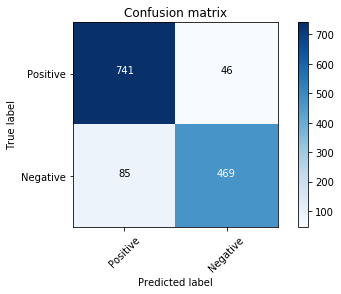

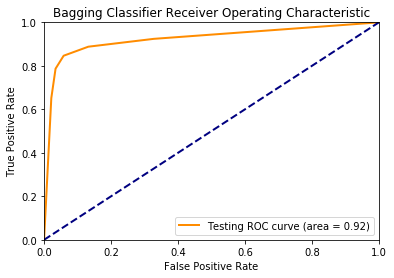

In [8]:
clf = make_pipeline(CountVectorizer(), TfidfTransformer(), BaggingClassifier(n_estimators=5)) 
clf.fit(train_data, train_labels)

predictions = clf.predict(test_data)
print("Accuracy: " + str(np.mean(predictions == test_labels)))

conf_mat = confusion_matrix(test_labels, predictions)

plt.figure()
plot_confusion_matrix(conf_mat, ["Positive", "Negative"])
plt.show()

class_probs = clf.predict_proba(test_data)
conf = [c[1] for c in class_probs]

fpr, tpr, thresholds = roc_curve(test_labels, conf, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Testing ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging Classifier Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#clf = make_pipeline(CountVectorizer(), TfidfTransformer(), BaggingClassifier(n_estimators=5)) 
#clf.fit(train_data, train_labels)

predictions = clf.predict(test_data)

print("Accuracy: " + str(accuracy_score(test_labels, predictions)))
p, r, f, _ = precision_recall_fscore_support(test_labels, predictions)
print("Precision: " + str(p))
print("Recall: " + str(r))
print("F1: " + str(f))

Accuracy: 0.9023117076808352
Precision: [0.89709443 0.91067961]
Recall: [0.94155019 0.8465704 ]
F1: [0.91878487 0.87745557]


In [ ]:
scores = cross_val_score(clf, train_data + test_data, train_labels + test_labels, cv=10)
scores.mean()